In [0]:
access_key = ''
secret_key = ''
encoded_secret_key = secret_key.replace("/", "%2F")
aws_bucket_name = "imdb-project-kc"
mount_name = "s3dataread"
#dbutils.fs.mount(f"s3a://{access_key}:{encoded_secret_key}@{aws_bucket_name}", f"/mnt/{mount_name}")

In [0]:
%pip install textblob

Python interpreter will be restarted.
  Using cached textblob-0.17.1-py2.py3-none-any.whl (636 kB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached regex-2023.10.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (773 kB)
Python interpreter will be restarted.


In [0]:
pip install wordcloud

Python interpreter will be restarted.
  Using cached wordcloud-1.9.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (460 kB)
Python interpreter will be restarted.


In [0]:
pip install --upgrade Pillow

Python interpreter will be restarted.
  Using cached Pillow-10.1.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.6 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.1
    Not uninstalling pillow at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-08708239-6808-48f5-bb2e-cdb315214196
    Can't uninstall 'Pillow'. No files were found to uninstall.
Python interpreter will be restarted.


## Feature Engineering

In [0]:
# Read cleaned data from the raw folder in s3
df_cleaned_review = spark.read.parquet("dbfs:/mnt/s3dataread/raw/review.parquet")
df_cleaned_business = spark.read.parquet("dbfs:/mnt/s3dataread/raw/business.parquet")

In [0]:
# Change the 'stars' column names for both tables, for joining purpose
df_cleaned_review = df_cleaned_review.withColumnRenamed("stars", "review_stars")
df_cleaned_business = df_cleaned_business.withColumnRenamed("stars", "business_stars")

In [0]:
# Get 10% of the data
sample_review = df_cleaned_review.sample(withReplacement=False, fraction=0.1, seed=21)
sample_business = df_cleaned_business.sample(withReplacement=False, fraction=0.1, seed=21)

In [0]:
sample_review.count()

Out[42]: 698852

In [0]:
# StringIndexer: create an index for each categories, the most frequent category starts with 0
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
indexed_sdf = indexer.fit(sample_business).transform(sample_business)
indexed_sdf.show()

+--------------------+-------+-------------+---------------+--------------+-----------+-----+------------+--------------+--------------------+-------------+
|         business_id|is_open|     latitude|      longitude|          city|postal_code|state|review_count|business_stars|            category|categoryIndex|
+--------------------+-------+-------------+---------------+--------------+-----------+-----+------------+--------------+--------------------+-------------+
|VpVvT7RY2NjvNgjDk...|      0|   40.0027546|    -75.2253166|   Bala Cynwyd|      19004|   PA|           8|           5.0| Arts & Entertain...|         26.0|
|HQIk1lXvoXPr9bEel...|      0|   40.0842069|    -75.2502304|Lafayette Hill|      19444|   PA|          63|           4.0|           Nightlife|          4.0|
|bZstQVsj-ZavCOyWb...|      1|   38.6234991|    -90.3204728|   Saint Louis|      63117|   MO|          36|           4.5|          Automotive|         10.0|
|bZstQVsj-ZavCOyWb...|      1|   38.6234991|    -90.320472

In [0]:
# FeatureHasher: transform categorical data into a numerical format that will be used in the model
from pyspark.ml.feature import FeatureHasher

hasher = FeatureHasher(numFeatures=5000, inputCols=["categoryIndex"],outputCol="category_features")
featurized_sdf = hasher.transform(indexed_sdf)
featurized_sdf.show()

+--------------------+-------+-------------+---------------+--------------+-----------+-----+------------+--------------+--------------------+-------------+--------------------+
|         business_id|is_open|     latitude|      longitude|          city|postal_code|state|review_count|business_stars|            category|categoryIndex|   category_features|
+--------------------+-------+-------------+---------------+--------------+-----------+-----+------------+--------------+--------------------+-------------+--------------------+
|VpVvT7RY2NjvNgjDk...|      0|   40.0027546|    -75.2253166|   Bala Cynwyd|      19004|   PA|           8|           5.0| Arts & Entertain...|         26.0|(5000,[2141],[26.0])|
|HQIk1lXvoXPr9bEel...|      0|   40.0842069|    -75.2502304|Lafayette Hill|      19444|   PA|          63|           4.0|           Nightlife|          4.0| (5000,[2141],[4.0])|
|bZstQVsj-ZavCOyWb...|      1|   38.6234991|    -90.3204728|   Saint Louis|      63117|   MO|          36|    

In [0]:
# Select columns in the new order
df_cleaned_review = sample_review.selectExpr("review_id","user_id","business_id", 
                   "date","text","review_stars")
df_cleaned_review.show(5)

+--------------------+--------------------+--------------------+-------------------+--------------------+------------+
|           review_id|             user_id|         business_id|               date|                text|review_stars|
+--------------------+--------------------+--------------------+-------------------+--------------------+------------+
|IBE--3kR0d_b1exUC...|om57XK20fbUgBN8I1...|8gY3LGFUMIQubovGb...|2020-08-15 18:36:52|We stopped here g...|         5.0|
|RKZBAD-Iam-30yFmc...|l4JyFgq1MzRgIA0SQ...|ZPwFVWoiqFOTbnhfS...|2019-01-08 23:01:31|The customer serv...|         1.0|
|GEoqz_gtlQiRvFYn0...|s4G4MQF_8OsNxt2RK...|z1xr2cfCDy6Hxq6QH...|2019-12-08 01:11:19|Before starting I...|         5.0|
|ptKyR5cEW3zIhEKFT...|n4IWzwt8-a9wxL388...|LViCv4ltuFF3xWn3y...|2017-04-26 22:43:21|Bought a car from...|         5.0|
|1j6JGBqtxB3syXyV7...|6kLnpi9_3ck2wVOkT...|PpJfYwwXhqr1nCNaU...|2020-02-21 22:57:21|Disappointed in t...|         1.0|
+--------------------+--------------------+-----

In [0]:
# Binarizer: create a new binary column, set stars that are equal or higher than 3 to 1, or 0 otherwise
from pyspark.ml.feature import Binarizer

binarizer = Binarizer(threshold=3.0, inputCol="review_stars", outputCol="binary_rating")
binarized_review_sdf = binarizer.transform(df_cleaned_review)
binarized_review_sdf.select(["text","review_stars","binary_rating"]).show(5)

+--------------------+------------+-------------+
|                text|review_stars|binary_rating|
+--------------------+------------+-------------+
|We stopped here g...|         5.0|          1.0|
|The customer serv...|         1.0|          0.0|
|Before starting I...|         5.0|          1.0|
|Bought a car from...|         5.0|          1.0|
|Disappointed in t...|         1.0|          0.0|
+--------------------+------------+-------------+
only showing top 5 rows



In [0]:
# RegexTokenizer: split up sentences into a list of individual words
from pyspark.ml.feature import Tokenizer, RegexTokenizer

regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\w+", gaps=False)
words_sdf = regexTokenizer.transform(binarized_review_sdf)
words_sdf.select(["text","review_stars","binary_rating","words"]).show(5)

+--------------------+------------+-------------+--------------------+
|                text|review_stars|binary_rating|               words|
+--------------------+------------+-------------+--------------------+
|We stopped here g...|         5.0|          1.0|[we, stopped, her...|
|The customer serv...|         1.0|          0.0|[the, customer, s...|
|Before starting I...|         5.0|          1.0|[before, starting...|
|Bought a car from...|         5.0|          1.0|[bought, a, car, ...|
|Disappointed in t...|         1.0|          0.0|[disappointed, in...|
+--------------------+------------+-------------+--------------------+
only showing top 5 rows



In [0]:
# StopWordsRemover: remove stop words
from pyspark.ml.feature import StopWordsRemover

stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Transform the DataFrame
df_transformed = stop_words_remover.transform(words_sdf)

df_transformed.select(["text","review_stars","binary_rating","words","filtered_words"]).show()

+--------------------+------------+-------------+--------------------+--------------------+
|                text|review_stars|binary_rating|               words|      filtered_words|
+--------------------+------------+-------------+--------------------+--------------------+
|We stopped here g...|         5.0|          1.0|[we, stopped, her...|[stopped, going, ...|
|The customer serv...|         1.0|          0.0|[the, customer, s...|[customer, servic...|
|Before starting I...|         5.0|          1.0|[before, starting...|[starting, tell, ...|
|Bought a car from...|         5.0|          1.0|[bought, a, car, ...|[bought, car, las...|
|Disappointed in t...|         1.0|          0.0|[disappointed, in...|[disappointed, 20...|
|First time here, ...|         5.0|          1.0|[first, time, her...|[first, time, fir...|
|We have used Acad...|         5.0|          1.0|[we, have, used, ...|[used, academy, m...|
|You have to go be...|         3.0|          0.0|[you, have, to, g...|[go, nashv

In [0]:
# HashingTF: represent the words in a fixed-size vector, which will be used in the model
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(numFeatures=4096, inputCol="filtered_words", outputCol="word_features")
term_freq_sdf = hashingTF.transform(df_transformed)
term_freq_sdf.select(["text","review_stars","binary_rating","words","filtered_words","word_features"]).show(5)

+--------------------+------------+-------------+--------------------+--------------------+--------------------+
|                text|review_stars|binary_rating|               words|      filtered_words|       word_features|
+--------------------+------------+-------------+--------------------+--------------------+--------------------+
|We stopped here g...|         5.0|          1.0|[we, stopped, her...|[stopped, going, ...|(4096,[514,578,84...|
|The customer serv...|         1.0|          0.0|[the, customer, s...|[customer, servic...|(4096,[81,132,346...|
|Before starting I...|         5.0|          1.0|[before, starting...|[starting, tell, ...|(4096,[6,167,193,...|
|Bought a car from...|         5.0|          1.0|[bought, a, car, ...|[bought, car, las...|(4096,[19,131,419...|
|Disappointed in t...|         1.0|          0.0|[disappointed, in...|[disappointed, 20...|(4096,[674,692,97...|
+--------------------+------------+-------------+--------------------+--------------------+-----

In [0]:
# Textblob for sentiment analysis
from textblob import TextBlob
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, isnan, when, count, udf

def sentiment_analysis(text):
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment
# Turn our function into a UDF
sentiment_analysis_udf = udf(sentiment_analysis, DoubleType())

term_freq_sdf = term_freq_sdf.withColumn("sentiment_score",
                                         sentiment_analysis_udf(df_cleaned_review['text'] ))

term_freq_sdf.select(["text","review_stars","binary_rating","words","filtered_words","word_features","sentiment_score"]).show(5)

+--------------------+------------+-------------+--------------------+--------------------+--------------------+--------------------+
|                text|review_stars|binary_rating|               words|      filtered_words|       word_features|     sentiment_score|
+--------------------+------------+-------------+--------------------+--------------------+--------------------+--------------------+
|We stopped here g...|         5.0|          1.0|[we, stopped, her...|[stopped, going, ...|(4096,[514,578,84...|                0.36|
|The customer serv...|         1.0|          0.0|[the, customer, s...|[customer, servic...|(4096,[81,132,346...|-0.06428571428571428|
|Before starting I...|         5.0|          1.0|[before, starting...|[starting, tell, ...|(4096,[6,167,193,...|  0.3590277777777777|
|Bought a car from...|         5.0|          1.0|[bought, a, car, ...|[bought, car, las...|(4096,[19,131,419...|              0.3125|
|Disappointed in t...|         1.0|          0.0|[disappointed

In [0]:
# Join review table with business table
df_join = term_freq_sdf.join(featurized_sdf, on="business_id", how="inner")
df_join.select(["categoryIndex","category_features","text","binary_rating","words","filtered_words","word_features","sentiment_score"]).show()

+-------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
|categoryIndex|   category_features|                text|binary_rating|               words|      filtered_words|       word_features|     sentiment_score|
+-------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+
|        175.0|(5000,[2141],[175...|Adorable shop. Th...|          1.0|[adorable, shop, ...|[adorable, shop, ...|(4096,[598,715,86...|  0.7666666666666666|
|          3.0| (5000,[2141],[3.0])|BULWARK OF OLD SC...|          0.0|[bulwark, of, old...|[bulwark, old, sc...|(4096,[8,64,97,10...| 0.08945312499999998|
|          0.0| (5000,[2141],[0.0])|One of my fave pl...|          1.0|[one, of, my, fav...|[one, fave, place...|(4096,[328,578,58...|              0.4475|
|         99.0|(5000,[2141],[99.0])|I strongly recomm...|       

## Modeling

In [0]:
# Import necessary packages
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import explode, col
from wordcloud import WordCloud
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Use VectorAssembler to combine features into a single column
feature_columns = ["category_features","word_features", "sentiment_score"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Split the data into 70% training and 30% test sets
train, test = df_join.randomSplit([0.7, 0.3], seed=21)

# Create a LogisticRegression Estimator
lr = LogisticRegression(featuresCol="features",labelCol="binary_rating",maxIter=10,regParam=0.3)

#Create a pipeline
pipeline = Pipeline(stages=[assembler,lr])

# Fit the model to the training data
model = pipeline.fit(train)

In [0]:
# Test the model on the testData
test_results = model.transform(test)
# Show the test results
test_results.select('probability','binary_rating','prediction').show()

+--------------------+-------------+----------+
|         probability|binary_rating|prediction|
+--------------------+-------------+----------+
|[0.45430199293507...|          0.0|       1.0|
|[0.82418524518742...|          0.0|       0.0|
|[0.30916720905987...|          0.0|       1.0|
|[0.23585920461729...|          0.0|       1.0|
|[0.14629693335883...|          1.0|       1.0|
|[0.46895462432242...|          0.0|       1.0|
|[0.10989172500230...|          1.0|       1.0|
|[0.11972565435875...|          1.0|       1.0|
|[0.16218464476003...|          1.0|       1.0|
|[0.59286742654104...|          0.0|       0.0|
|[0.55163356880114...|          1.0|       0.0|
|[0.12349272796950...|          1.0|       1.0|
|[0.32906284426392...|          0.0|       1.0|
|[0.54012767173173...|          0.0|       0.0|
|[0.44358279385459...|          0.0|       1.0|
|[0.76211506307826...|          0.0|       0.0|
|[0.98481583977550...|          0.0|       0.0|
|[0.24721247321908...|          1.0|    

In [0]:
# Create a confusion matrix
cm = test_results.groupby('binary_rating').pivot('prediction').count().fillna(0).collect()

# Create a function to get the metrics
def calculate_recall_precision(cm):
    tn = cm[0][1] # True Negative
    fp = cm[0][2] # False Positive
    fn = cm[1][1] # False Negative
    tp = cm[1][2] # True Positive
    precision = tp / ( tp + fp )
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score
    
accuracy, precision, recall, f1_score = calculate_recall_precision(cm)

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 score: {:.4f}".format(f1_score))

Accuracy: 0.8731
Precision: 0.8581
Recall: 0.9753
F1 score: 0.9130


In [0]:
# Define the parameter grid for grid search
param_grid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [5, 10, 15]) \
    .build()

# Create a cross-validator
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=param_grid,
                    evaluator=BinaryClassificationEvaluator(labelCol="binary_rating", metricName="areaUnderROC"),
                    numFolds=3)


# Run cross-validation and choose the best set of parameters
cv_model = cv.fit(train)

In [0]:
# Average metrics for each model
print("Average Metrics for Each model: ", cv_model.avgMetrics)

Average Metrics for Each model:  [0.9481571737588298, 0.9489851347499881, 0.9490010888558694]


In [0]:
# Gather the metrics and parameters of the model with the best average metrics
hyperparams = cv_model.getEstimatorParamMaps()[np.argmax(cv_model.avgMetrics)]

# Print out the list of hyperparameters for the best model
for i in range(len(hyperparams.items())):
    print([x for x in hyperparams.items()][i])

# Choose the best model
bestModel = cv_model.bestModel
#print("Area under ROC curve:", bestModel.summary.areaUnderROC)

(Param(parent='LogisticRegression_15924a6981d1', name='maxIter', doc='max number of iterations (>= 0).'), 15)


In [0]:
# Use the model 'bestModel' to predict the test set
test_results2 = bestModel.transform(test)

# Show the results
test_results2.select('probability','binary_rating','prediction').show(5)

# Evaluate the predictions. Area Under ROC curve
evaluator=BinaryClassificationEvaluator(labelCol="binary_rating", metricName="areaUnderROC")
auc = evaluator.evaluate(test_results2)
print(f'AUC = {auc:.2f}')

+--------------------+-------------+----------+
|         probability|binary_rating|prediction|
+--------------------+-------------+----------+
|[0.45420609984420...|          0.0|       1.0|
|[0.82356561098721...|          0.0|       0.0|
|[0.30931712901943...|          0.0|       1.0|
|[0.23591890436399...|          0.0|       1.0|
|[0.14616025600082...|          1.0|       1.0|
+--------------------+-------------+----------+
only showing top 5 rows

AUC = 0.95


In [0]:
# Create a confusion matrix
cm2 = test_results2.groupby('binary_rating').pivot('prediction').count().fillna(0).collect()

# Create a function to get the metrics
def calculate_recall_precision(cm2):
    tn = cm2[0][1] # True Negative
    fp = cm2[0][2] # False Positive
    fn = cm2[1][1] # False Negative
    tp = cm2[1][2] # True Positive
    precision = tp / ( tp + fp )
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score
    
accuracy, precision, recall, f1_score = calculate_recall_precision(cm2)

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 score: {:.4f}".format(f1_score))

Accuracy: 0.8731
Precision: 0.8581
Recall: 0.9754
F1 score: 0.9130


In [0]:
# Save the best model
model_path ="dbfs:/mnt/s3dataread/models/best_model_largeSample"
bestModel.write().overwrite().save(model_path)

## Visualization

LogisticRegression_15924a6981d1__aggregationDepth 2
LogisticRegression_15924a6981d1__elasticNetParam 0.0
LogisticRegression_15924a6981d1__family auto
LogisticRegression_15924a6981d1__featuresCol features
LogisticRegression_15924a6981d1__fitIntercept True
LogisticRegression_15924a6981d1__labelCol binary_rating
LogisticRegression_15924a6981d1__maxBlockSizeInMB 0.0
LogisticRegression_15924a6981d1__maxIter 15
LogisticRegression_15924a6981d1__predictionCol prediction
LogisticRegression_15924a6981d1__probabilityCol probability
LogisticRegression_15924a6981d1__rawPredictionCol rawPrediction
LogisticRegression_15924a6981d1__regParam 0.3
LogisticRegression_15924a6981d1__standardization True
LogisticRegression_15924a6981d1__threshold 0.5
LogisticRegression_15924a6981d1__tol 1e-06
Out[25]: Text(0.5, 1.0, 'ROC Curve')

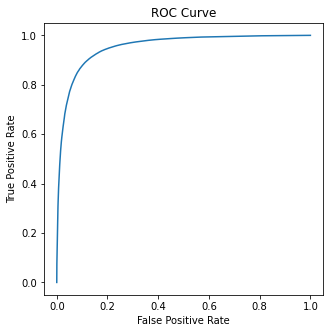

In [0]:
parammap = cv_model.bestModel.stages[1].extractParamMap()
for p, v in parammap.items():
    print(p, v)
# Grab the model from Stage 1 of the pipeline
model = cv_model.bestModel.stages[1]

# Plot the ROC curve
plt.figure(figsize=(5,5))
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect(),
         label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")

In [0]:
# Convert the PySpark DataFrame to a Pandas DataFrame
predictions_pd = test_results2.select("binary_rating", "prediction").toPandas()

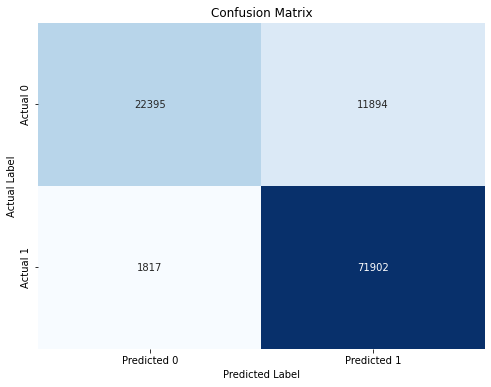

In [0]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(predictions_pd["binary_rating"], predictions_pd["prediction"])

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])  
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

Out[30]: <AxesSubplot:>

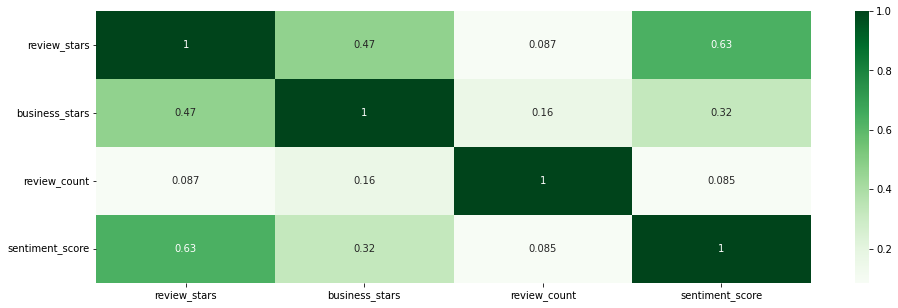

In [0]:
# Convert the numeric values to vector columns
vector_column = "correlation_features"
# Make a list of all of the numeric columns
numeric_columns = ['review_stars', 'business_stars', 'review_count', 'sentiment_score']
# Use a vector assembler to combine all of the numeric columns together
cm_assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
df_vector = cm_assembler.transform(df_join).select(vector_column)
# Create the correlation matrix, then get just the values and convert to a list
matrix = Correlation.corr(df_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()
# Convert the correlation to a Pandas dataframe
correlation_matrix_pd = pd.DataFrame(data=correlation_matrix, columns=numeric_columns,
index=numeric_columns)
# Create the plot using Seaborn
plt.figure(figsize=(16,5))
sns.heatmap(correlation_matrix_pd,
xticklabels=correlation_matrix_pd.columns.values,
yticklabels=correlation_matrix_pd.columns.values, cmap="Greens", annot=True)

In [0]:
# Filter the data, select data that has binary_rating equal to 0
low_rating_text = df_join.filter(col("binary_rating") == 0)
# Filter the data, select data that has binary_rating equal to 1
high_rating_text = df_join.filter(col("binary_rating") == 1)

In [0]:
# Split the array into individual words
low_rating_word = low_rating_text.select(explode("filtered_words").alias("word"))
high_rating_word = high_rating_text.select(explode("filtered_words").alias("word"))

# Count the frequency of each word
low_rating_word_counts = low_rating_word.groupBy("word").count()
high_rating_word_counts = high_rating_word.groupBy("word").count()

# Convert to a Pandas DataFrame for WordCloud
low_rating_pandas = low_rating_word_counts.toPandas()
high_rating_pandas = high_rating_word_counts.toPandas()

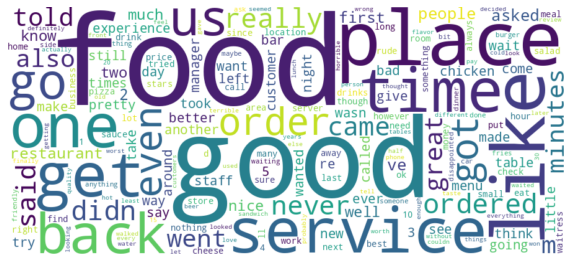

In [0]:
# Generate the WordCloud for low stars rating
low_rating_wordcloud = WordCloud(width=900, height=400, background_color="white").generate_from_frequencies(dict(zip(low_rating_pandas["word"], low_rating_pandas["count"])))

# Display the WordCloud for low stars rating
plt.figure(figsize=(10, 5))
plt.imshow(low_rating_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

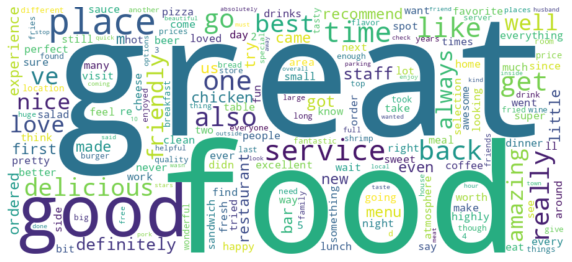

In [0]:
# Generate the WordCloud for high stars rating
high_rating_wordcloud = WordCloud(width=900, height=400, background_color="white").generate_from_frequencies(dict(zip(high_rating_pandas["word"], high_rating_pandas["count"])))

# Display the WordCloud for high stars rating
plt.figure(figsize=(10, 5))
plt.imshow(high_rating_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

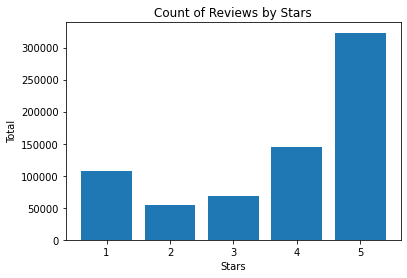

In [0]:
# Group by 'stars' and calculate the sum of each of them
grouped_data = sample_review.groupBy("review_stars").count()

# Convert the PySpark DataFrame to a Pandas DataFrame
grouped_pd = grouped_data.toPandas()

# Plot the bar chart using Matplotlib
plt.bar(grouped_pd["review_stars"], grouped_pd["count"])
plt.xlabel("Stars")
plt.ylabel("Total")
plt.title("Count of Reviews by Stars")
plt.show()